In [ ]:
##only run this code on colab
! pip install neurodiffeq

In [2]:
#only run this on colab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path
sys.path.append('drive/MyDrive/PINN/PINN_program/code/train')
print(sys.path)

Mounted at /content/drive
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', 'drive/MyDrive/PINN/PINN_program/code/train']


In [3]:
##this file defines all utility functions to use to train a multihead
##neural network to solve a series of PDEs of one form
from Fisher_models import *

#import all required packages
import torch
import torch.nn as nn
import torch.nn.functional as F

from neurodiffeq import diff
from neurodiffeq.neurodiffeq import unsafe_diff as unsafe_diff
from neurodiffeq.conditions import IVP, DirichletBVP, DirichletBVP2D, BundleIVP, BundleDirichletBVP
from neurodiffeq.solvers import Solver1D, Solver2D, BundleSolver1D
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.generators import Generator1D, Generator2D

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import time
from tqdm.auto import tqdm

In [4]:
##construct a model of 10 heads
k=10
model = Multihead_model(k=k, act = nn.functional.silu, bias=True)
model

Multihead_model(
  (linear1): Linear(in_features=2, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=512, bias=True)
  (final_layers): ModuleList(
    (0-9): 10 x Linear(in_features=256, out_features=1, bias=True)
  )
)

In [5]:
k1 = 2
K2 = np.linspace(1, 2, 8)[:5]
A_list = [0.5, -0.5]; b = 0.5; k=10

truth_functions = []; Forcing_functions = []

for k2 in K2:
  for A in A_list:
    truth_functions.append(truth_decorator_trig(A, k1, k2, b=b))
    Forcing_functions.append(forcing_decorator_trig(A, k1, k2, D=1))

#compute the truth solution
truth_solution = [truth_functions[i](X_grid[:,0],
                            X_grid[:,1]).cpu().detach().numpy().reshape(round(X_grid.shape[0]**.5), -1) for i in range(k)]


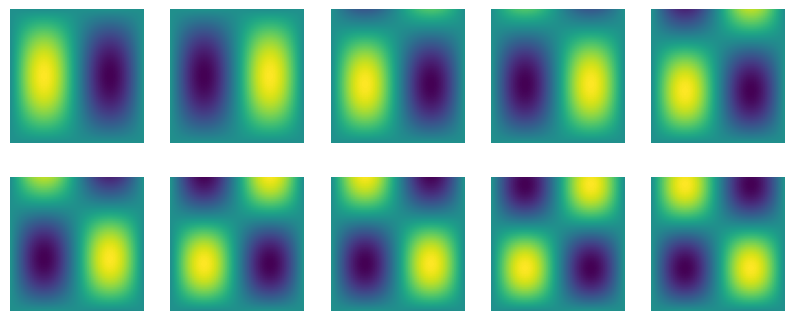

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4));
for i, sol in enumerate(truth_solution):
  j = i//5; k = i%5;
  ax[j][k].imshow(sol[::-1,:])
  ax[j][k].axis('off')

In [8]:
##train the network
b = 0.5
learning_rate = 1e-3 ##initial learning rate
num_iter= 25000 ##number of iterations
step_size = 100 ##how often the exponential decay is applied
gamma = 0.98 ##exponential decay scale

##define the sampling parameters
interior_grid = (50, 50)
x_boundary_num = 100
t_boundary_num = 100 #on both t boundaries
#define boundary condition
boundary_value = b
##define smapling method
method='equally-spaced-noisy'

##define the weights in each component of the loss
pde_weight = 1; bc_weight = 1; data_weight = 1

##define the optimizer
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
##define the exponential learning rate decay scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [9]:
##train the model
loss_trace, pde_trace, bc_trace, data_trace = train(model, optimizer, loss, num_iter, Forcing_functions, truth_functions,
          boundary_value, D = 1, interior_grid=interior_grid, x_boundary_num=x_boundary_num, t_boundary_num=t_boundary_num,
          every=100, pde_weight=pde_weight, bc_weight=bc_weight, data_weight=data_weight, scheduler=scheduler, method=method)

  0%|          | 0/25000 [00:00<?, ?it/s]

100th Iter: total 14.08457170422922, pde 14.021421881275694, bc 0.0021626316311204622, data 0.060987191322404016
200th Iter: total 9.235570064072158, pde 9.04369309518967, bc 0.11252266773451557, data 0.07935430114797272
300th Iter: total 1.5583388871305666, pde 1.4445620302992321, bc 0.07671622158902004, data 0.037060635242314434
400th Iter: total 0.46123447084646146, pde 0.38253629437391046, bc 0.056520147323565015, data 0.022178029148985954
500th Iter: total 0.31702890954427937, pde 0.25622920884372125, bc 0.04091187075006508, data 0.019887829950493065
600th Iter: total 0.17305984047193318, pde 0.13452471908050712, bc 0.02634086341746641, data 0.012194257973959646
700th Iter: total 0.1262134012292586, pde 0.10394860933091678, bc 0.015034610796650227, data 0.00723018110169159
800th Iter: total 0.07622992408392798, pde 0.06416309513256728, bc 0.008527922898787631, data 0.003538906052573062
900th Iter: total 0.25227173066738756, pde 0.24297806823844376, bc 0.0066978960542428845, data 0

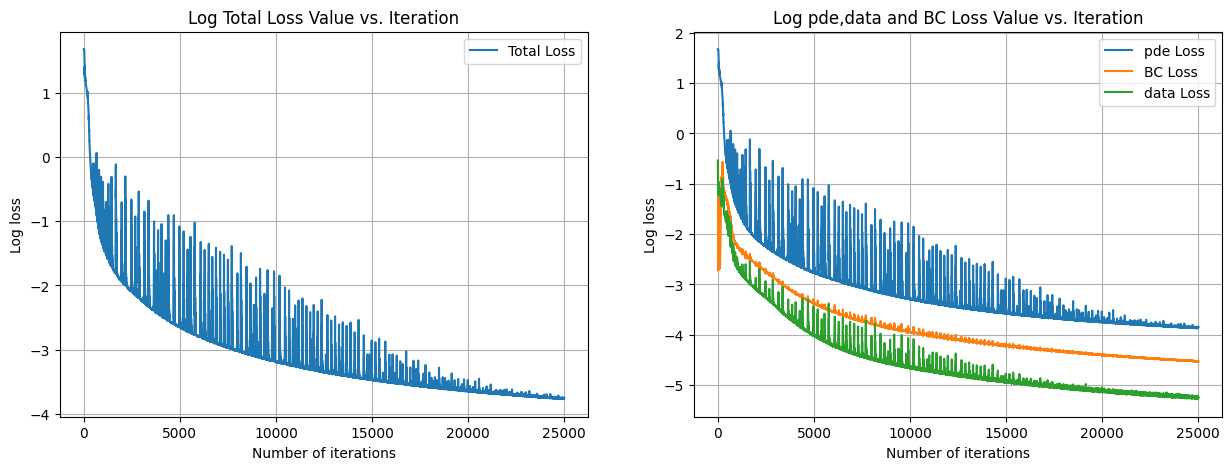

In [10]:
plot_loss(loss_trace, pde_trace, bc_trace, data_trace)

In [11]:
##compute the NN solutions
NN_solution, _ = model(X_grid.to('cuda'))
NN_solution = NN_solution[:, :, 0].cpu().detach().numpy()
NN_solution = [NN_solution[i, :].reshape(round(X_grid.shape[0]**.5), -1) for i in range(10)]

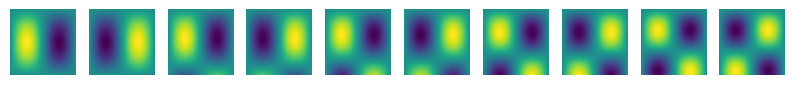

In [12]:
fig, ax = plt.subplots(1, 10, figsize=(10, 3));
for i, sol in enumerate(NN_solution):
  ax[i].imshow(sol);
  ax[i].axis('off');

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
##go to the code folder where I can import the PDE_models module
%cd 'gdrive/MyDrive/PINN/PINN_program/code'

/content/gdrive/MyDrive/PINN/PINN_program/code


In [15]:
##log and save the record
log = {
    'model': model,
    'optimizer':optimizer,
    'bias': True,
    'forcing_info': {
        'A': A_list,
        'K1': k1,
        'K2': K2,
        'b': b
    },
    'lr': learning_rate,
    'num_iter': num_iter,
    'step_size': step_size,
    'gamma': gamma,
    'interior_grid': interior_grid,
    'x_boundary_num': x_boundary_num,
    't_boundary_num': t_boundary_num,
    'boundary_value': b,
    'pde_weight': pde_weight,
    'bc_weight': bc_weight,
    'data_weight': data_weight,
    'loss_trace': {
        'total': loss_trace,
        'pde': pde_trace,
        'bc': bc_trace,
        'data': data_trace
    },
    'method': 'equally-spaced-noisy'
}

In [16]:
import pickle
path = 'train/experiment_log/Fisher_10head_model_apr1_trig_1phase2.pickle'
file = open(path, 'wb')
pickle.dump(model.cpu(), file)
file.close()

In [17]:
import pickle
path = 'train/experiment_log/Fisher_10head_log_apr1_trig_1phase2.pickle'
file = open(path, 'wb')
pickle.dump(log, file)
file.close()